# Pairplots jb08-nrlmsise-nn

In [2]:
import sys

sys.path.append("../")

import thermonets as tn
import datetime
import numpy as np
import matplotlib.pyplot as plt
from nrlmsise00 import msise_flat
import cartopy.crs as ccrs
import pyatmos
from tqdm import tqdm

The EOP file 'finals2000A.all' in /Users/dario.izzo/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in /Users/dario.izzo/src/iers/ is already the latest.


## First we create the data inferring the three models

In [3]:
# We first establish the longitude latitude grid thickness
n_grid = 400
lons = np.linspace(0, 2 * np.pi, n_grid)
lats = np.linspace(-np.pi / 2, np.pi / 2, n_grid)
lons_m, lats_m = np.meshgrid(lons, lats, indexing='ij')

# Altitude in km
alt = 400

# Date
date = datetime.datetime(2018, 4, 22, 6, 13, 35)

First the NRLMSISE-00 thermoNET

In [4]:
ap, f107, f107a, doy, sid = tn.get_nrlmsise00_attributes(date)
nrlmsise00_tn = tn.nrlmsise00_tn(
    hs=[alt], lons=lons, lats=lats, f107a=f107a, f107=f107, ap=ap, doy=doy, sid=sid
).reshape((n_grid, n_grid))

Then NRLMSISE

In [5]:
# we extract the target density (running NRLMSISE-00):
nrlmsise00 = (
    msise_flat(
        time=date,
        alt=alt,
        lon=np.rad2deg(lons_m.ravel()),
        lat=np.rad2deg(lats_m.ravel()),
        f107a=f107a,
        f107=f107,
        ap=ap,
    )[:, 5]
    * 1e3
)
nrlmsise00 = nrlmsise00.reshape((n_grid, n_grid))

Then JB08 thermoNET

In [6]:
f107, f107a, s107, s107a, m107, m107a, y107, y107a, dDstdT, doy, sid = (
    tn.get_jb08_attributes(date)
)
jb08_tn = tn.jb08_tn(
    [alt],
    lons,
    lats,
    f107,
    f107a,
    s107,
    s107a,
    m107,
    m107a,
    y107,
    y107a,
    dDstdT,
    doy,
    sid,
).reshape(n_grid, n_grid)

The Space Weather files 'SOLFSMY.TXT' and 'DTCFILE.TXT' in /Users/dario.izzo/src/sw-data/ are already the latest.


Then JB08, this will be slow as pyatmos does not allow vectorization

In [7]:
# we extract the target density (running JB-08):
swfile = pyatmos.download_sw_jb2008()
swdata = pyatmos.read_sw_jb2008(swfile)

# we extract the target density (running JB-08):
jb08 = np.zeros((n_grid, n_grid))
for i, lon in enumerate(tqdm(lons)):
    for j, lat in enumerate(lats):
        jb08[i, j] = pyatmos.jb2008(
            date, (np.rad2deg(lat), np.rad2deg(lon), alt), swdata
        ).rho

The Space Weather files 'SOLFSMY.TXT' and 'DTCFILE.TXT' in /Users/dario.izzo/src/sw-data/ are already the latest.


100%|██████████| 400/400 [04:49<00:00,  1.38it/s]


## We make the pairlplot

In [8]:
def plot_model(lons_m, lats_m, data, text, axes):
    axes.pcolormesh(
        np.rad2deg(lons_m),
        np.rad2deg(lats_m),
        data,
        transform=ccrs.PlateCarree()
    )
    axes.set_global()
    axes.coastlines()
    axes.set_title(text)
    return axes

def plot_model_error(lons_m, lats_m, data1, data2, axes):
    rel_error = (data1-data2)/data1
    max_mape = np.mean(np.abs((data1-data2)/data1))*100

    im = axes.pcolormesh(
        np.rad2deg(lons_m),
        np.rad2deg(lats_m),
        rel_error,
        transform=ccrs.PlateCarree(),
        cmap="magma"
    )
    axes.set_global()
    axes.coastlines()
    axes.set_title(f"{max_mape:.1f}%")

    return axes

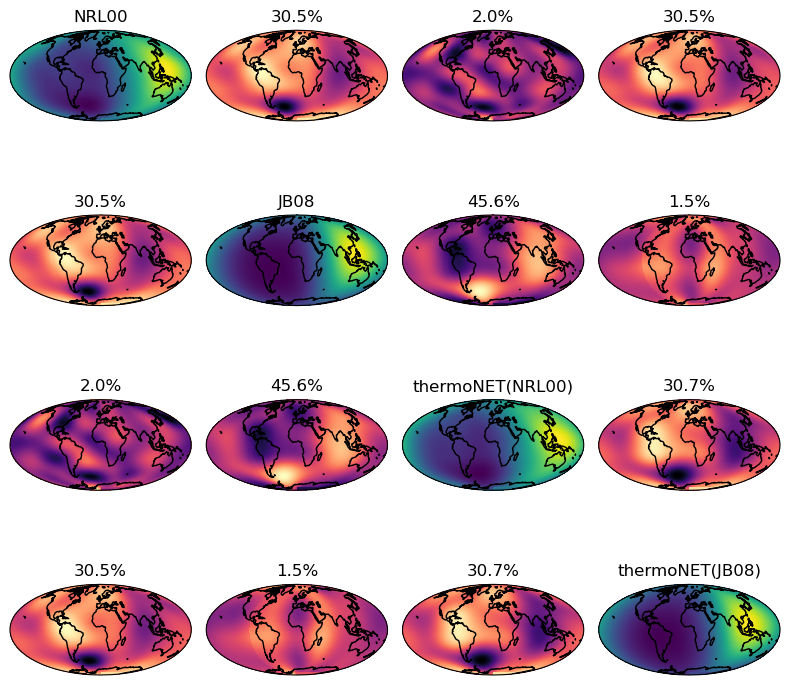

In [9]:
# We create a figure with a globe projection on top:
fig, ax = plt.subplots(
    figsize=(8, 8),
    nrows=4,
    ncols=4,
    subplot_kw={"projection": ccrs.Mollweide(central_longitude=0)},
)

# we plot NRLMSISE-00 on the first figure:
plot_model(lons_m, lats_m, nrlmsise00, "NRL00", ax[0,0])
plot_model_error(lons_m, lats_m, nrlmsise00, jb08, ax[0,1])
plot_model_error(lons_m, lats_m, nrlmsise00, nrlmsise00_tn, ax[0,2])
plot_model_error(lons_m, lats_m, nrlmsise00, jb08_tn, ax[0,3])

plot_model(lons_m, lats_m, jb08, "JB08", ax[1,1])
plot_model_error(lons_m, lats_m, nrlmsise00, jb08, ax[1,0])
plot_model_error(lons_m, lats_m, jb08, nrlmsise00_tn, ax[1,2])
plot_model_error(lons_m, lats_m, jb08, jb08_tn, ax[1,3])

plot_model(lons_m, lats_m, nrlmsise00_tn, "thermoNET(NRL00)", ax[2,2])
plot_model_error(lons_m, lats_m, nrlmsise00, nrlmsise00_tn, ax[2,0])
plot_model_error(lons_m, lats_m, jb08, nrlmsise00_tn, ax[2,1])
plot_model_error(lons_m, lats_m, nrlmsise00_tn, jb08_tn, ax[2,3])

plot_model(lons_m, lats_m, jb08_tn, "thermoNET(JB08)", ax[3,3])
plot_model_error(lons_m, lats_m, nrlmsise00, jb08_tn, ax[3,0])
plot_model_error(lons_m, lats_m, jb08, jb08_tn, ax[3,1])
plot_model_error(lons_m, lats_m, nrlmsise00_tn, jb08_tn, ax[3,2])

plt.tight_layout()


In [12]:
fig.savefig("pairplots.png", dpi=600)

## We add here a few cells computing the difference between jb08 and NRLMSISE globally
These cells are slow (no vectorization) and should only be run occasionally.

In [69]:
err = 0
for i in range(10000):
    lon = np.random.uniform(0, 2 * np.pi)
    lat = np.random.uniform(-np.pi / 2, np.pi / 2)
    # Altitude in km
    alt = np.random.uniform(180, 1000)

    # Date
    days = np.arange(365)
    year = np.random.choice([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022])
    minutes = np.random.uniform(low=0.,high=1440.)
    day = np.random.choice(days)
    date = datetime.datetime(year, 1, 1, 0, 0, 0)+datetime.timedelta(days=int(day))+datetime.timedelta(minutes=minutes)

    a,b,c,_,_ = tn.get_nrlmsise00_attributes(date)
    rho_NRL = msise_flat(
            time=date,
            alt=alt,
            lon=np.rad2deg(lon),
            lat=np.rad2deg(lat),
            f107=a,f107a=b,ap=c
        )[5]*1e3

    rho_jb08 = pyatmos.jb2008(
                date, (np.rad2deg(lat), np.rad2deg(lon), alt), swdata
            ).rho
    err += abs(rho_NRL-rho_jb08)/rho_NRL*100
    print(i, err / (i+1), end="\r")
